<a href="https://colab.research.google.com/github/woodsj1206/Train-Yolov8-Instance-Segmentation-On-Custom-Dataset/blob/main/Train_Yolov8_Instance_Segmentation_On_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pretrained Model: https://github.com/woodsj1206/Train-Yolov8-Instance-Segmentation-On-Custom-Dataset/blob/main/Train_Yolov8_Instance_Segmentation_On_Custom_Dataset.ipynb

Dataset: https://www.kaggle.com/datasets/whats2000/breast-cancer-semantic-segmentation-bcss

#Step 1: Checking GPU Availability
Check if a GPU is available in your Google Colab environment. A GPU can significantly accelerate the training process of deep learning models like YOLOv8.

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Step 2: Unzipping Dataset Files
Unzip the dataset files containing images and annotations. These files are typically compressed to save space and are now being extracted for use in training the YOLOv8 model.

**NOTE:** Ensure that the images and their corresponding annotation files have the same names (e.g., image_1.png should have an associated image_1.txt file).

In [2]:
'''
# Unzip the zip file containing the images
!unzip -q 'REPLACE_WITH_YOUR_IMAGE_ZIP_FILE_PATH' -d '/content/images'

# Unzip the zip file containing the annotations
!unzip -q 'REPLACE_WITH_YOUR_ANNOTATIONS_ZIP_FILE_PATH' -d '/content/annotations'
'''

"\n# Unzip the zip file containing the images\n!unzip -q 'REPLACE_WITH_YOUR_IMAGE_ZIP_FILE_PATH' -d '/content/images'\n\n# Unzip the zip file containing the annotations\n!unzip -q 'REPLACE_WITH_YOUR_ANNOTATIONS_ZIP_FILE_PATH' -d '/content/annotations'\n"

#Step 3: Installing Ultralytics
Install Ultralytics, a library that simplifies working with YOLO object detection models.

In [3]:
# Install Ultralytics library
!pip install ultralytics

# Import necessary modules from Ultralytics
from ultralytics import YOLO

#Step 4: Mounting Google Drive
Mount Google Drive to the Colab environment, enabling access to files stored in your Google Drive.

In [4]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive to '/content/Google_Drive'
drive.mount('/content/drive')

# Optional: verify path
!ls /content/drive/MyDrive/BreastCancerProject/Datasets/BCSS/BCSS_512

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
config.yaml  data  testing  train_512  train_mask_512  val_512	val_mask_512


#Step 5: Define Root Directory and Create Subdirectories
Define the root directory for your project and create necessary subdirectories to organize your data.

In [6]:
import os

# Updated project root path for local Colab environment
ROOT_DIR = '/content/BCSS_512'

# Define YOLOv8 dataset structure paths under BCSS_512
DATA_DIR = os.path.join(ROOT_DIR, 'data')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
IMAGES_TRAIN_DIR = os.path.join(IMAGES_DIR, 'train')
IMAGES_VAL_DIR = os.path.join(IMAGES_DIR, 'val')

LABELS_DIR = os.path.join(DATA_DIR, 'labels')
LABELS_TRAIN_DIR = os.path.join(LABELS_DIR, 'train')
LABELS_VAL_DIR = os.path.join(LABELS_DIR, 'val')

TESTING_DIR = os.path.join(ROOT_DIR, 'testing')

# Create all necessary directories if not exist
for directory in [
    DATA_DIR, IMAGES_DIR, IMAGES_TRAIN_DIR, IMAGES_VAL_DIR,
    LABELS_DIR, LABELS_TRAIN_DIR, LABELS_VAL_DIR, TESTING_DIR
]:
    os.makedirs(directory, exist_ok=True)

print(f"✅ Project directories created under: {ROOT_DIR}")


✅ Project directories created under: /content/BCSS_512


#Step 6: Organize Dataset for Training and Validation
Organize the dataset by moving images and corresponding annotations into separate directories for training and validation.

In [7]:
import shutil
import os
from tqdm import tqdm

# Updated source paths (since BCSS_512 is now in /content)
SRC_TRAIN_IMAGES = '/content/BCSS_512/train_512'
SRC_VAL_IMAGES = '/content/BCSS_512/val_512'
SRC_TRAIN_MASKS = '/content/BCSS_512/train_mask_512'
SRC_VAL_MASKS = '/content/BCSS_512/val_mask_512'

# Copy training images and masks
print("Copying training images...")
for file in tqdm(os.listdir(SRC_TRAIN_IMAGES)):
    shutil.copy(os.path.join(SRC_TRAIN_IMAGES, file), os.path.join(IMAGES_TRAIN_DIR, file))

print("Copying training masks...")
for file in tqdm(os.listdir(SRC_TRAIN_MASKS)):
    shutil.copy(os.path.join(SRC_TRAIN_MASKS, file), os.path.join(LABELS_TRAIN_DIR, file))

# Copy validation images and masks
print("Copying validation images...")
for file in tqdm(os.listdir(SRC_VAL_IMAGES)):
    shutil.copy(os.path.join(SRC_VAL_IMAGES, file), os.path.join(IMAGES_VAL_DIR, file))

print("Copying validation masks...")
for file in tqdm(os.listdir(SRC_VAL_MASKS)):
    shutil.copy(os.path.join(SRC_VAL_MASKS, file), os.path.join(LABELS_VAL_DIR, file))

print("✅ Dataset successfully copied to YOLO directories.")


Copying training images...


100%|██████████| 6000/6000 [00:43<00:00, 138.63it/s]


Copying training masks...


100%|██████████| 6010/6010 [00:01<00:00, 5899.73it/s]


Copying validation images...


100%|██████████| 2768/2768 [00:18<00:00, 152.56it/s]


Copying validation masks...


100%|██████████| 2768/2768 [00:00<00:00, 5258.41it/s]

✅ Dataset successfully copied to YOLO directories.


In [8]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2

def mask_to_yolo(mask_path, output_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h, w = mask.shape

    with open(output_path, 'w') as f:
        for contour in contours:
            if len(contour) < 3:
                continue
            points = contour.squeeze().astype(float)
            points[:, 0] /= w
            points[:, 1] /= h
            flat = points.flatten()
            flat = np.clip(flat, 0, 1)

            label = '0'
            coords = ' '.join([f'{x:.6f}' for x in flat])
            f.write(f'{label} {coords}\n')

# Updated DATA_DIR since BCSS_512 is now in /content
DATA_DIR = '/content/BCSS_512/data'
os.makedirs(f'{DATA_DIR}/labels/train', exist_ok=True)
os.makedirs(f'{DATA_DIR}/labels/val', exist_ok=True)

# Process masks again with updated paths
for split in ['train', 'val']:
    mask_dir = f'/content/BCSS_512/{split}_mask_512'
    label_dir = f'{DATA_DIR}/labels/{split}'

    for mask_path in tqdm(glob(os.path.join(mask_dir, '*.png')), desc=f'Processing {split} masks'):
        file_name = os.path.splitext(os.path.basename(mask_path))[0] + '.txt'
        output_path = os.path.join(label_dir, file_name)
        mask_to_yolo(mask_path, output_path)


Processing val masks: 100%|██████████| 2768/2768 [00:03<00:00, 840.76it/s]


In [9]:
import os
import shutil
from glob import glob
from tqdm import tqdm

VAL_IMG_DIR = '/content/BCSS_512/data/images/val'
VAL_LBL_DIR = '/content/BCSS_512/data/labels/val'

# Step 1: Trim to 200 validation images
val_images = sorted(glob(f'{VAL_IMG_DIR}/*.png'))
if len(val_images) > 200:
    print("🔎 Trimming validation set to 200 matching samples...")
    extra_imgs = val_images[200:]
    for img_path in tqdm(extra_imgs, desc="Removing extra val images"):
        os.remove(img_path)

# Step 2: Remove unmatched labels
valid_images = set(os.path.splitext(os.path.basename(p))[0] for p in glob(f'{VAL_IMG_DIR}/*.png'))
label_paths = glob(f'{VAL_LBL_DIR}/*.txt')

removed = 0
for lbl in label_paths:
    lbl_name = os.path.splitext(os.path.basename(lbl))[0]
    if lbl_name not in valid_images:
        os.remove(lbl)
        removed += 1

# Final count
final_imgs = len(glob(f'{VAL_IMG_DIR}/*.png'))
final_lbls = len(glob(f'{VAL_LBL_DIR}/*.txt'))

print("✅ Validation set trimmed.")
print(f"📸 Validation images: {final_imgs}")
print(f"🏷️  Validation labels: {final_lbls}")


🔎 Trimming validation set to 200 matching samples...


Removing extra val images: 100%|██████████| 2568/2568 [00:00<00:00, 6151.74it/s]


✅ Validation set trimmed.
📸 Validation images: 200
🏷️  Validation labels: 200


In [10]:
!head /content/BCSS_512/data/labels/train/*.txt | head -n 20

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_0_size512.txt <==
0 0.000000 0.000000 0.000000 0.998047 0.998047 0.998047 0.998047 0.000000

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1024_size512.txt <==
0 0.000000 0.000000 0.000000 0.998047 0.998047 0.998047 0.998047 0.000000

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1536_size512.txt <==
0 0.000000 0.000000 0.000000 0.998047 0.998047 0.998047 0.998047 0.000000

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_2048_size512.txt <==
0 0.000000 0.000000 0.000000 0.998047 0.998047 0.998047 0.998047 0.000000

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_2560_size512.txt <==
0 0.000000 0.000000 0.000000 0.998047 0.998047 0.998047 0.998047 0.000000

==> /content/BCSS_512/data/labels/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_512_size512.t

In [11]:
from glob import glob

all_train = glob('/content/BCSS_512/train_mask_512/*')
all_val = glob('/content/BCSS_512/val_mask_512/*')

print(f"Files in train_mask_512: {len(all_train)}")
print(f"Files in val_mask_512: {len(all_val)}")

print("Sample train files:", all_train[:5])
print("Sample val files:", all_val[:5])

Files in train_mask_512: 6010
Files in val_mask_512: 2768
Sample train files: ['/content/BCSS_512/train_mask_512/TCGA-E9-A5FL-DX1_xmin45595_ymin47283_MPP-0_0_0_size512.png', '/content/BCSS_512/train_mask_512/TCGA-BH-A1FC-DX1_xmin52216_ymin33355_MPP-0_1536_2560_size512.png', '/content/BCSS_512/train_mask_512/TCGA-A7-A6VV-DX1_xmin48674_ymin37475_MPP-0_1024_2560_size512.png', '/content/BCSS_512/train_mask_512/TCGA-A2-A3XT-DX1_xmin83566_ymin29931_MPP-0_1536_512_size512.png', '/content/BCSS_512/train_mask_512/TCGA-BH-A0B3-DX1_xmin82526_ymin42184_MPP-0_0_0_size512.png']
Sample val files: ['/content/BCSS_512/val_mask_512/TCGA-E2-A14X-DX1_xmin88836_ymin66393_MPP-0_512_2048_size512.png', '/content/BCSS_512/val_mask_512/TCGA-OL-A5RW-DX1_xmin5772_ymin6839_MPP-0_0_0_size512.png', '/content/BCSS_512/val_mask_512/TCGA-OL-A5D7-DX1_xmin114443_ymin22490_MPP-0_1024_2048_size512.png', '/content/BCSS_512/val_mask_512/TCGA-E2-A574-DX1_xmin54962_ymin47475_MPP-0_1536_0_size512.png', '/content/BCSS_512/val_ma

#Step 7: Generate YAML Configuration File
Create a YAML configuration file specifying the paths to the training and validation datasets, as well as the class names (labels) used in your dataset.

In [12]:
import yaml

data = {
    'path': '/content/BCSS_512/data',
    'train': 'images/train',
    'val': 'images/val',
    'names': {
        0: 'tumor'
    }
}

with open('/content/config.yaml', 'w') as f:
    yaml.dump(data, f)

print("✅ Local config.yaml written to /content/config.yaml")


✅ Local config.yaml written to /content/config.yaml


#Step 8: Train the YOLOv8 Model
Train the YOLOv8 model using the provided dataset configuration and save the training results.

In [13]:
from ultralytics import YOLO
import os
import shutil

# Load a lightweight model
model = YOLO('yolov8n-seg.pt')

# Run for 10 epochs, on 20% of the data
results = model.train(data='/content/config.yaml', epochs=10, imgsz=512, batch=8, cache='disk', fraction=.2)

# Optional: zip the results
shutil.make_archive(base_name=f"{ROOT_DIR}/runs", format='zip', root_dir='/content/runs')


Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/config.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=disk, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.2, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

train: Scanning /content/BCSS_512/data/labels/train.cache... 1200 images, 8 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]
train: Caching images (0.9GB Disk): 100%|██████████| 1200/1200 [00:00<00:00, 26590.12it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2116.3±513.5 MB/s, size: 518.0 KB)


val: Scanning /content/BCSS_512/data/labels/val.cache... 200 images, 14 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
val: Caching images (0.1GB Disk): 100%|██████████| 200/200 [00:00<00:00, 95596.67it/s]


Plotting labels to runs/segment/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/segment/train11
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.2497     0.9289     0.9706      1.048          8        512: 100%|██████████| 150/150 [16:15<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:18<00:00,  6.02s/it]

                   all        200        186       0.86      0.925       0.85      0.782       0.84      0.903      0.814       0.75



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.1596     0.2426     0.4407     0.9654          8        512: 100%|██████████| 150/150 [15:15<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:15<00:00,  5.83s/it]

                   all        200        186       0.86      0.925      0.815      0.662      0.845      0.909      0.777      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.154     0.2735     0.3318     0.9638          8        512: 100%|██████████| 150/150 [15:12<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:05<00:00,  5.05s/it]

                   all        200        186      0.859      0.925      0.804      0.734      0.839      0.903      0.769      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.1395      0.229     0.2512     0.9598          8        512: 100%|██████████| 150/150 [14:58<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:05<00:00,  5.07s/it]

                   all        200        186       0.86      0.925      0.812      0.736       0.84      0.903      0.774      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.1169     0.2061     0.2004     0.9446          8        512: 100%|██████████| 150/150 [15:58<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:25<00:00,  6.56s/it]

                   all        200        186      0.861       0.93      0.827      0.751      0.845      0.909      0.789      0.718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.1077     0.2103     0.1824     0.9405          8        512: 100%|██████████| 150/150 [17:31<00:00,  7.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:10<00:00,  5.42s/it]

                   all        200        186       0.86      0.925      0.832      0.691       0.84      0.903      0.792      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G    0.09936     0.1984     0.1583     0.9305          8        512: 100%|██████████| 150/150 [15:22<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]

                   all        200        186       0.86      0.925      0.825      0.757       0.84      0.903      0.786      0.712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G    0.08167     0.2181     0.1392     0.9266          8        512: 100%|██████████| 150/150 [14:51<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:03<00:00,  4.87s/it]

                   all        200        186       0.86      0.925      0.827      0.756       0.84      0.903      0.787      0.725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G    0.06834     0.1914     0.1239     0.9265          8        512: 100%|██████████| 150/150 [14:42<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:02<00:00,  4.83s/it]

                   all        200        186       0.86      0.925      0.837      0.769       0.84      0.903      0.798      0.737



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G    0.05773      0.184     0.1103     0.9136          8        512: 100%|██████████| 150/150 [14:45<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:03<00:00,  4.88s/it]

                   all        200        186       0.86      0.925      0.807      0.742       0.84      0.903      0.777      0.709



10 epochs completed in 2.775 hours.
Optimizer stripped from runs/segment/train11/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train11/weights/best.pt, 6.8MB

Validating runs/segment/train11/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:04<00:57,  4.82s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:12<01:08,  6.24s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:10<00:00,  5.40s/it]


                   all        200        186       0.86      0.925      0.851      0.782       0.84      0.903      0.814       0.75
Speed: 5.6ms preprocess, 284.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train11


'/content/BCSS_512/runs.zip'

#Step 9: View Training Results
Display the training results and the confusion matrix generated during the training process.

📊 Displaying: runs/segment/train11/results.png


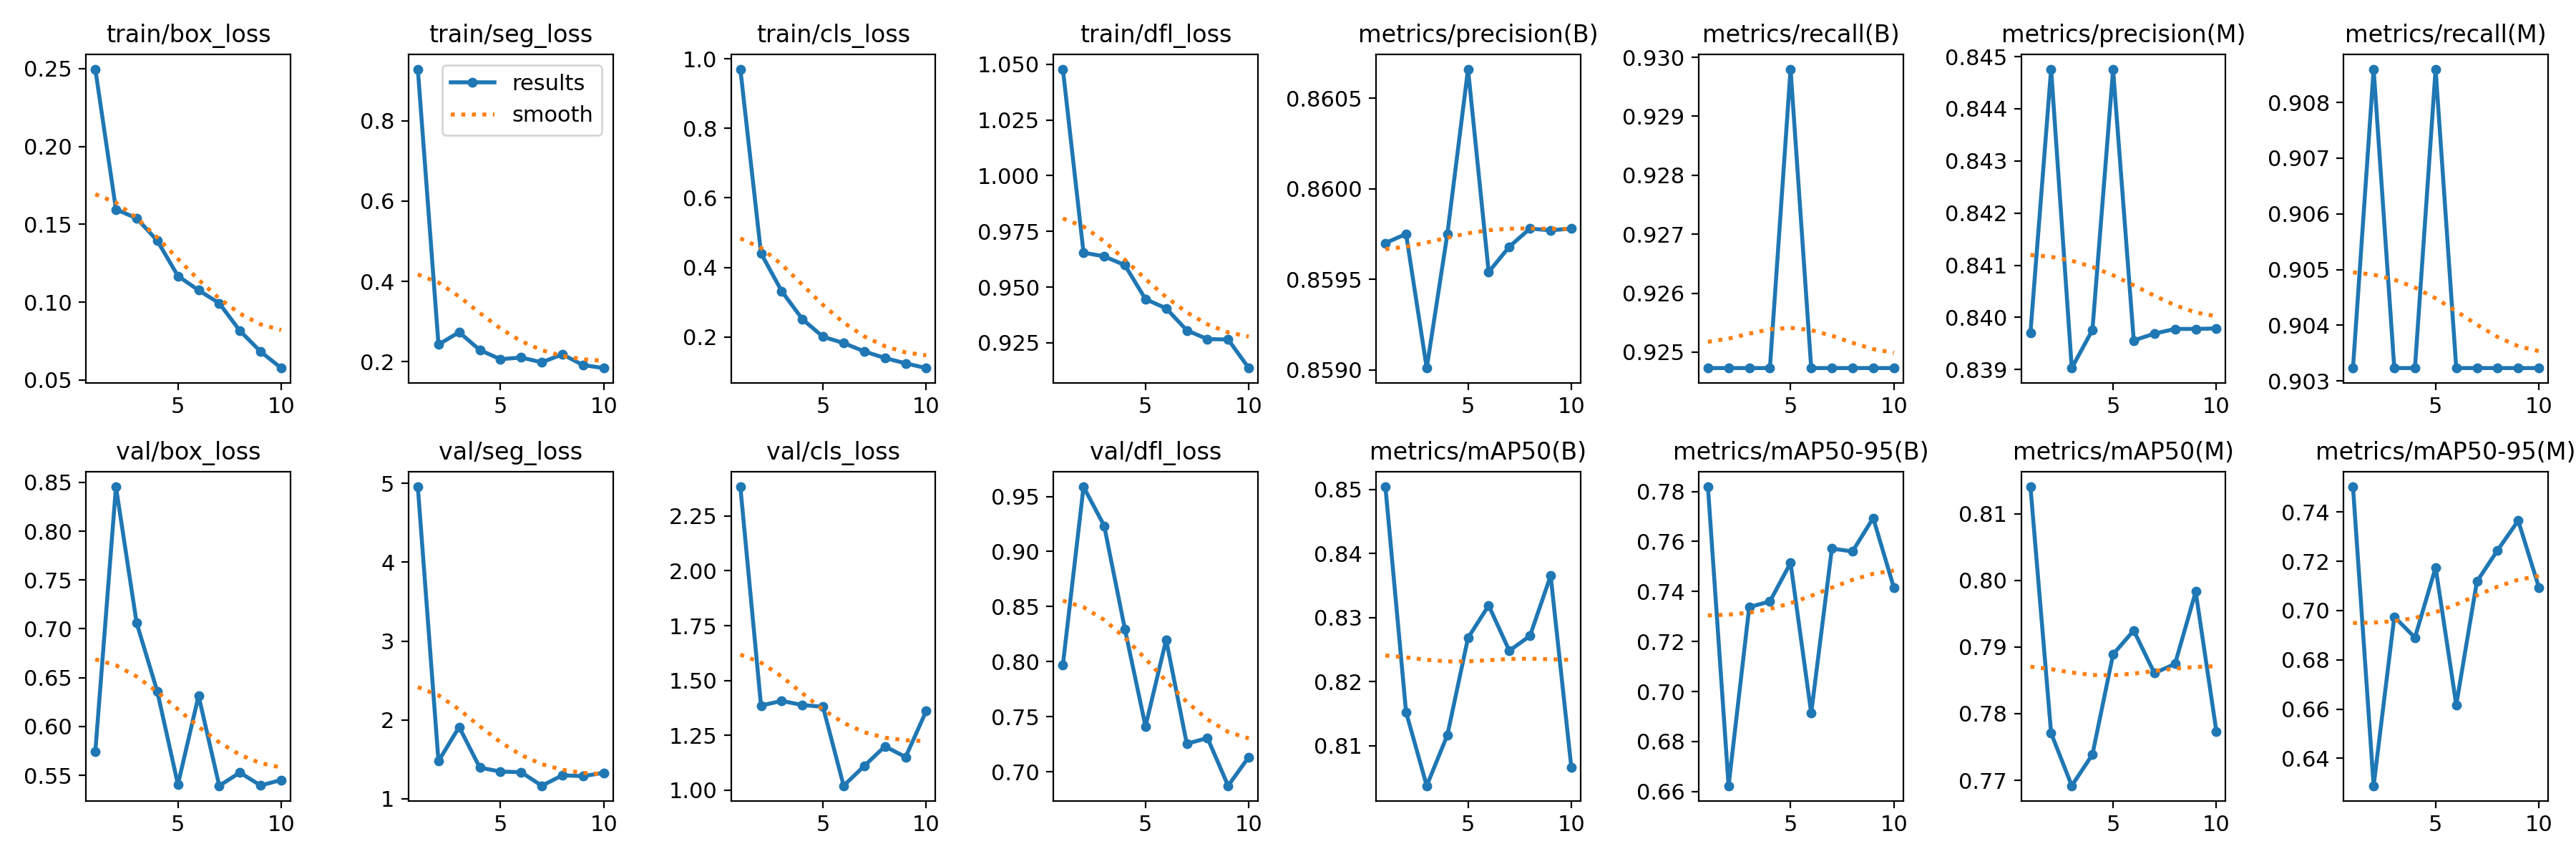

In [16]:
import os
from IPython.display import Image, display
from glob import glob

# Find all results.png files inside runs/segment/
result_images = glob('runs/segment/*/results.png')

if result_images:
    latest_result = sorted(result_images)[-1]
    print(f"📊 Displaying: {latest_result}")
    display(Image(filename=latest_result))
else:
    print("❌ No results.png found. Training may not have completed or saved correctly.")


🧩 Displaying: runs/segment/train11/confusion_matrix.png


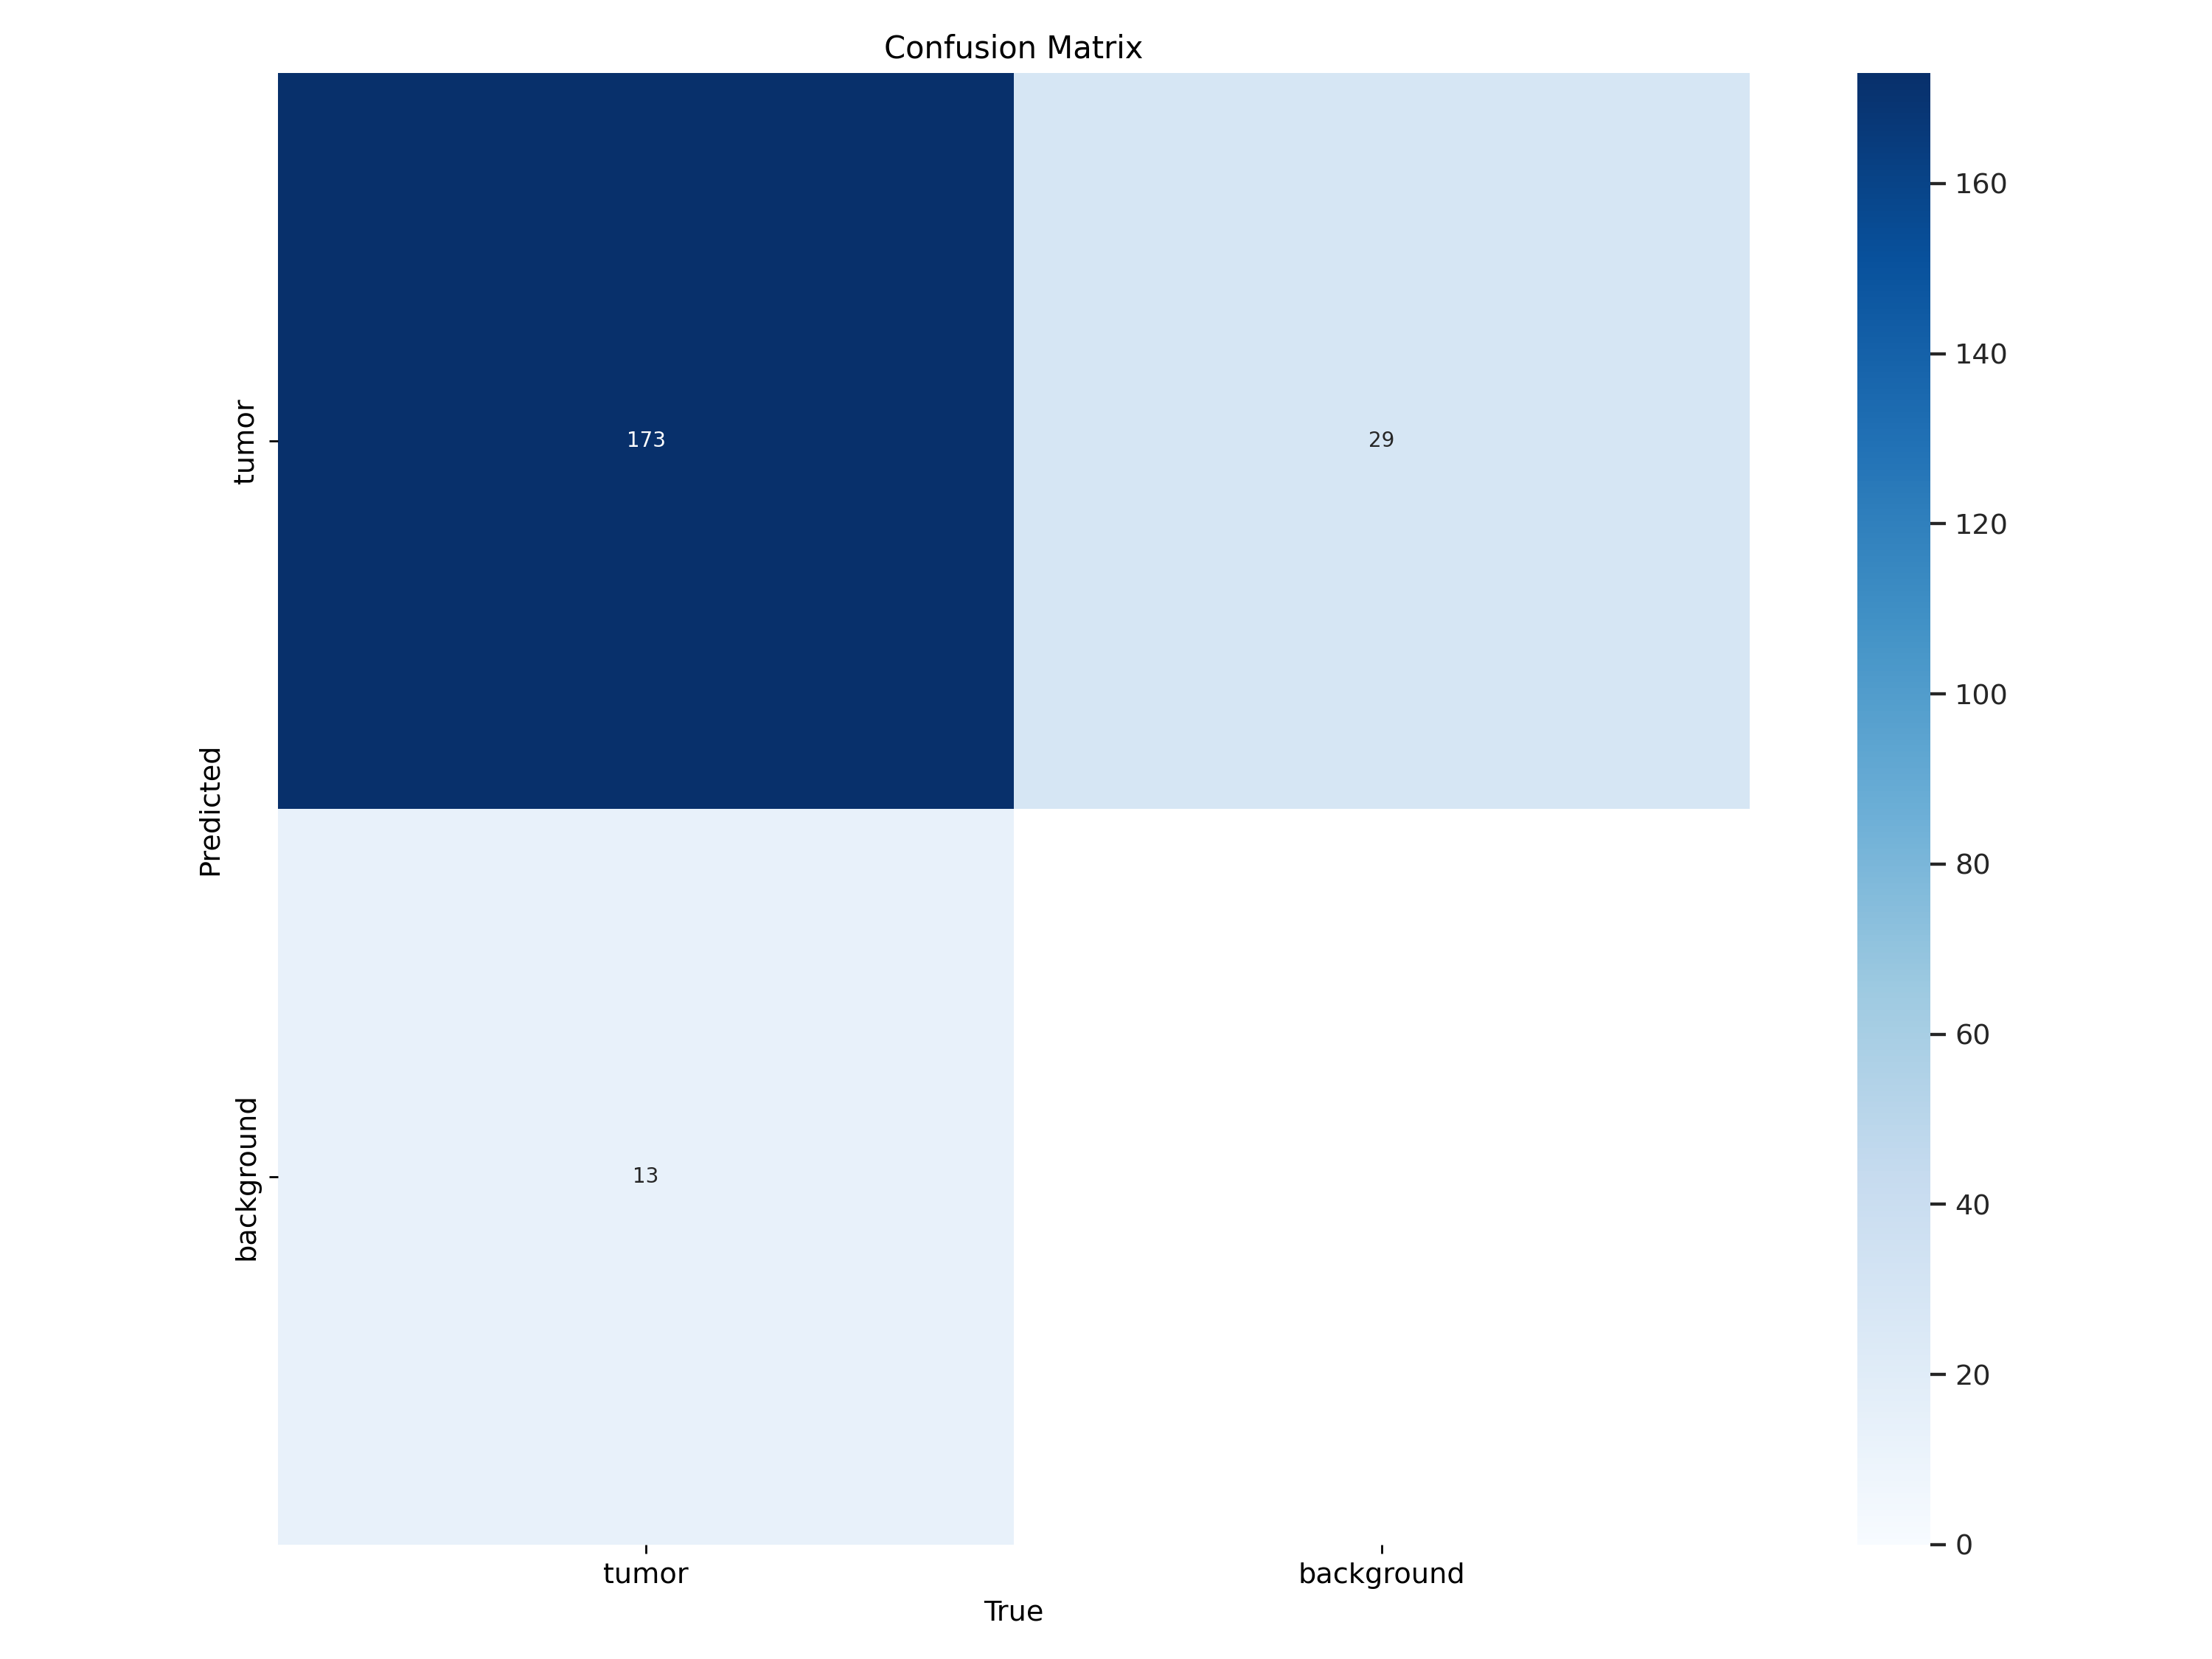

In [17]:
import os
from IPython.display import Image, display
from glob import glob

# Find all confusion_matrix.png files inside runs/segment/
confusion_images = glob('runs/segment/*/confusion_matrix.png')

if confusion_images:
    latest_confusion = sorted(confusion_images)[-1]
    print(f"🧩 Displaying: {latest_confusion}")
    display(Image(filename=latest_confusion))
else:
    print("❌ No confusion_matrix.png found. Validation may not have completed or saved it.")
